In [35]:
# Code wrotten by Roman Bachmann
# This script illustrate the performance of BayesBiNN on synthetic data for classification and regression tasks.
import os
import pickle
import random
from ipypb import track
import numpy as np
import sklearn.datasets 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type(torch.FloatTensor)

from models.simple_models import MLP, MLP_STE
from utils.train_utils import adjust_learning_rate
from optimizers.BayesBiNN import BayesBiNN

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import palettable
mpl.style.use('default')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Binary Neural Networks using Bayes

This notebook contains the code used to create the visualizations of the toy problems in the "Training Binary Neural Networks using the Bayesian Learning Rule" paper.

## 1 Binary Classification - Two moons

### 1.1 Dataset

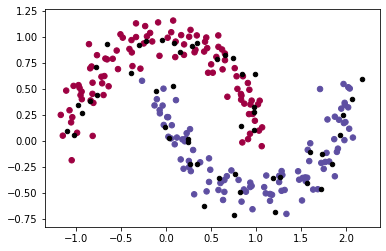

In [36]:
np.random.seed(0)
X_orig, y = sklearn.datasets.make_moons(200, noise=0.1, random_state=0)
Xt_orig, yt = sklearn.datasets.make_moons(50, noise=0.1, random_state=0)
plt.scatter(X_orig[:,0], X_orig[:,1], s=30, c=y, cmap=plt.cm.Spectral)
plt.scatter(Xt_orig[:,0], Xt_orig[:,1], s=20, color='black', cmap=plt.cm.Spectral)

In [37]:
X_orig = torch.from_numpy(X_orig).float()
y = torch.from_numpy(y).float().reshape(-1,1)

Xt_orig = torch.from_numpy(Xt_orig).float()
yt = torch.from_numpy(yt).float().reshape(-1,1)

Normalizing the train and test input data.

In [38]:
X_mean, X_std = X_orig.mean(dim=0), X_orig.std(dim=0)

X = (X_orig - X_mean) / X_std
Xt = (Xt_orig - X_mean) / X_std

### 1.2 Training BayesBiNN

In [39]:
torch.manual_seed(0)
np.random.seed(0)

epochs_bb = 3000
train_samples = 5
lr_start = 1e-3
lr_decay = 0.1
lr_decay_epochs = [1500, 2500]

model_bb = MLP(X.shape[1], [64,64], y.shape[1], act_func='tanh')
criterion_bb = nn.BCEWithLogitsLoss()
optimizer_bb = BayesBiNN(model_bb, len(X), lr=lr_start, betas=0.99, 
                 num_samples=train_samples, temperature=1,
                 reweight=1, prior_lamda=None, lamda_init=15, lamda_std=0)

for i in track(range(epochs_bb)):
    if i in lr_decay_epochs:
        for param_group in optimizer_bb.param_groups:
            param_group['lr'] *=  lr_decay
    def closure():
        optimizer_bb.zero_grad()
        y_pred = model_bb.forward(X)
        loss = criterion_bb(y_pred, y)
        return loss, y_pred
    loss, y_pred = optimizer_bb.step(closure)

 [████████████████████████████████████████████████████████████] 3000/3000 [00:18<00:00, 0.01s/it]

### 1.3 Training STE

In [40]:
torch.manual_seed(0)
np.random.seed(0)

epochs_ste = 3000
lr_start = 1e-1
lr_decay = 0.1
lr_decay_epochs = [1500, 2500]

model_ste = MLP_STE(X.shape[1], [64,64], y.shape[1], act_func='tanh')
criterion_ste = nn.BCEWithLogitsLoss()
optimizer_ste = optim.Adam(model_ste.parameters(), lr=lr_start)

for i in track(range(epochs_ste)):
    if i in lr_decay_epochs:
        for param_group in optimizer_ste.param_groups:
            param_group['lr'] *=  lr_decay
    
    optimizer_ste.zero_grad()
    y_pred = model_ste.forward(X)
    loss = criterion_ste(y_pred, y)
    loss.backward()
    
    for p in list(model_ste.parameters()):
        if hasattr(p, 'org'):
            p.data.copy_(p.org)

    optimizer_ste.step()

    for p in list(model_ste.parameters()):
        if hasattr(p, 'org'):
            p.org.copy_(p.data.clamp_(-1, 1))

 [████████████████████████████████████████████████████████████] 3000/3000 [00:06<00:00, 0.00s/it]

### 1.4 Plotting

In [41]:
def setup_grid(X, h=0.01, buffer=0.5):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer
    y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    return grid, xx, yy

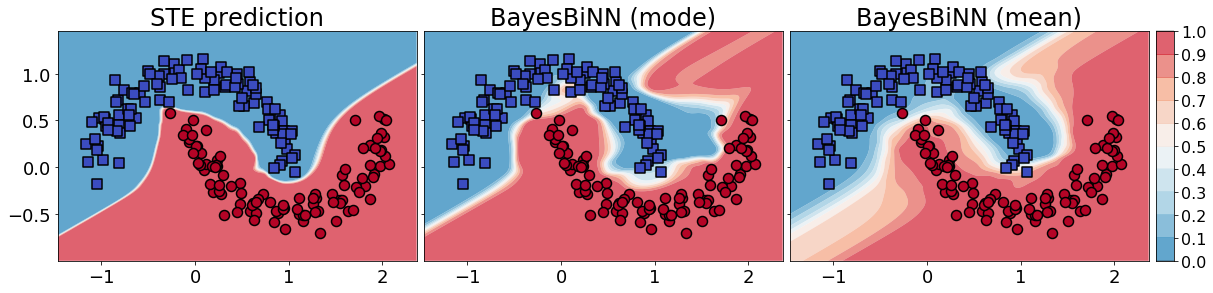

In [42]:
yf = y.flatten()
grid_orig, xx, yy = setup_grid(X_orig, h=0.01, buffer=0.3)
grid = (grid_orig - X_mean) / X_std

ms = 100
clevels = 9
title_fs = 24
ticks_fs = 18
cmap_fg = plt.cm.coolwarm
cmap_bg = palettable.colorbrewer.diverging.RdBu_5_r.get_mpl_colormap()


fig = plt.figure(figsize=(20,8))

ax = AxesGrid(fig, 111,
              nrows_ncols=(1,3),
              axes_pad=0.1,
              cbar_mode='single',
              cbar_location='right',
              cbar_pad=0.1)


# ----- Panel 1: STE deterministic -----

Z = model_ste.predict(grid).reshape(xx.shape)

c = ax[0].contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.7, levels=clevels, antialiased=True)
ax[0].scatter(X_orig[yf==0, 0], X_orig[yf==0, 1], color=cmap_fg(0), s=ms, lw=1.5, edgecolors='black', marker='s')
ax[0].scatter(X_orig[yf==1, 0], X_orig[yf==1, 1], color=cmap_fg(0.999), s=ms, lw=1.5, edgecolors='black')
ax[0].set_title('STE prediction', fontsize=title_fs)
ax[0].tick_params(axis='both', which='major', labelsize=ticks_fs)


# ----- Panel 2: BayesBiNN Posterior Mean -----
Z = optimizer_bb.get_mc_predictions(model_bb.forward, grid, raw_noises=None)
Z = torch.sigmoid(torch.stack(Z)).mean(dim=0).reshape(xx.shape).detach()

c = ax[1].contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.7, levels=clevels, antialiased=True)
ax[1].scatter(X_orig[yf==0, 0], X_orig[yf==0, 1], color=cmap_fg(0), s=ms, lw=1.5, edgecolors='black', marker='s')
ax[1].scatter(X_orig[yf==1, 0], X_orig[yf==1, 1], color=cmap_fg(0.999), s=ms, lw=1.5, edgecolors='black')
ax[1].set_title('BayesBiNN (mode)', fontsize=title_fs)
ax[1].tick_params(axis='both', which='major', labelsize=ticks_fs)


# ----- Panel 3: BayesBiNN Sampled -----
torch.manual_seed(0)
n_samples = 10
raw_noises = []
for mc_sample in range(n_samples):
    raw_noises.append(torch.bernoulli(torch.sigmoid(2*optimizer_bb.state['lamda'])))
Z = optimizer_bb.get_mc_predictions(model_bb.forward, grid, raw_noises=raw_noises)
Z = torch.sigmoid(torch.stack(Z)).mean(dim=0).reshape(xx.shape).detach()

c = ax[2].contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.7, levels=clevels, antialiased=True)
ax[2].scatter(X_orig[yf==0, 0], X_orig[yf==0, 1], color=cmap_fg(0), s=ms, lw=1.5, edgecolors='black', marker='s')
ax[2].scatter(X_orig[yf==1, 0], X_orig[yf==1, 1], color=cmap_fg(0.999), s=ms, lw=1.5, edgecolors='black')
ax[2].set_title('BayesBiNN (mean)', fontsize=title_fs)
ax[2].tick_params(axis='both', which='major', labelsize=ticks_fs)


# ----- Colorbar -----

cbar = ax.cbar_axes[0].colorbar(c, alpha=0.7)
cbar.ax.set_yticks(np.arange(0, 1.1, 1 / (clevels+1)))
cbar.ax.tick_params(axis='both', which='major', labelsize=16)

os.makedirs('./figs', exist_ok=True)
plt.savefig('./figs/bb_vs_ste.pdf', dpi=300)
plt.show()

## 2 Regression

### 2.1 Snelson dataset

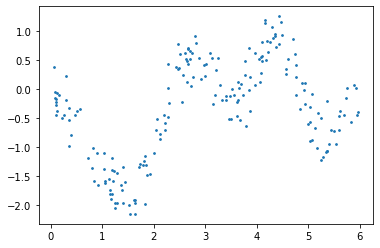

In [43]:
def load_snelson_data(n=200, dtype=np.float64):
    if n > 200:
        raise ValueError('Only 200 data points on snelson.')

    def _load_snelson(filename):
        with open('./data/snelson/{fn}'.format(fn=filename), "r") as f:
            return np.array([float(i) for i in f.read().strip().split("\n")],
                            dtype=dtype)

    train_x = _load_snelson("train_inputs")
    train_y = _load_snelson("train_outputs")
    test_x = _load_snelson("test_inputs")
    perm = np.random.permutation(train_x.shape[0])
    train_x = train_x[perm][:n]
    train_y = train_y[perm][:n]
    
    return train_x, train_y, test_x

X_train, y_train, X_test = load_snelson_data()
plt.scatter(X_train, y_train, s=3)

In [44]:
X_train = torch.from_numpy(X_train).unsqueeze(1).float()
y_train = torch.from_numpy(y_train).unsqueeze(1).float()
X_test = torch.from_numpy(X_test).unsqueeze(1).float()

Normalizing the train and test input data.

In [45]:
X_mean, X_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
y_train = (y_train - y_mean) / y_std

### 2.2 Training BayesBiNN

In [52]:
torch.manual_seed(0)
np.random.seed(0)

epochs = 5000
train_samples = 1
lr_start, lr_end = 1e-4, 1e-5
lr_decay = (lr_end/lr_start)**(1.0/epochs)

model = MLP(X_train.shape[1], [64,64], y_train.shape[1], act_func='tanh',
            use_bn=True, learn_bn=False, only_last_bn=True)
criterion = nn.MSELoss()
optimizer = BayesBiNN(model, X_train.shape[0], lr=lr_start, betas=0.99, 
                 num_samples=train_samples, temperature=1,
                 lamda_init=10, lamda_std=0, reweight=1)

for i in track(range(epochs)):
    adjust_learning_rate(lr_decay, optimizer, i)
    def closure():
        optimizer.zero_grad()
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        return loss, y_pred
    loss, y_pred = optimizer.step(closure)

 [████████████████████████████████████████████████████████████] 5000/5000 [00:07<00:00, 0.00s/it]

In [53]:
# Get posterior mean prediction
y_pred_mean = optimizer.get_mc_predictions(model.forward, X_test, raw_noises=None)[0].detach()

torch.manual_seed(0)
np.random.seed(0)

# Get mean and std of samples
n_samples = 10
raw_noises = []
for i in range(n_samples):        
    raw_noises.append(torch.bernoulli(torch.sigmoid(2*optimizer.state['lamda'])))
y_preds = optimizer.get_mc_predictions(model.forward, X_test, raw_noises=raw_noises)
y_preds = torch.stack(y_preds).detach()

y_preds_mean = y_preds.mean(dim=0)
y_preds_std = y_preds.std(dim=0)

### 2.3 Training STE

In [50]:
torch.manual_seed(0)
np.random.seed(0)

epochs_ste = 5000
lr_start = 1e-1

model_ste = MLP(X_train.shape[1], [64,64], y_train.shape[1], act_func='tanh',
            use_bn=True, learn_bn=False, only_last_bn=True)
criterion_ste = nn.MSELoss()
optimizer_ste = optim.Adam(model_ste.parameters(), lr=lr_start)

for i in track(range(epochs_ste)):
    optimizer_ste.zero_grad()
    y_pred = model_ste.forward(X_train)
    loss = criterion_ste(y_pred, y_train)
    loss.backward()
    
    for p in list(model_ste.parameters()):
        if hasattr(p, 'org'):
            p.data.copy_(p.org)

    optimizer_ste.step()

    for p in list(model_ste.parameters()):
        if hasattr(p, 'org'):
            p.org.copy_(p.data.clamp_(-1, 1))

 [████████████████████████████████████████████████████████████] 5000/5000 [00:07<00:00, 0.00s/it]

In [51]:
y_pred = model_ste.forward(X_test).detach()

### 2.4 Plotting

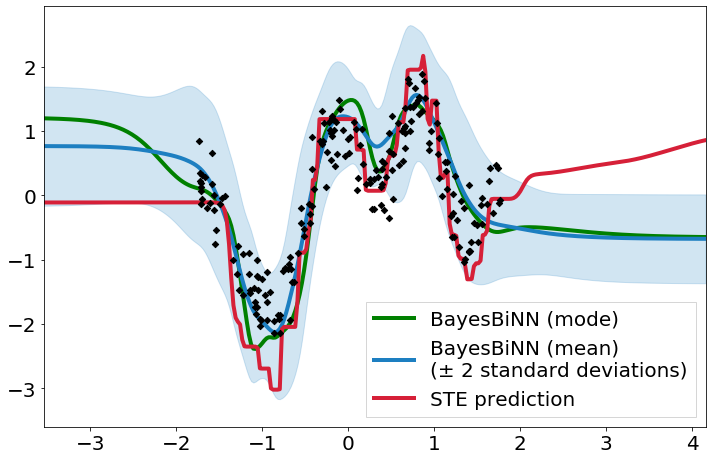

In [16]:
color1 = '#D62038'
color2 = '#1D7FC1'

plt.figure(figsize=(10,6.5))

plt.scatter(X_train, y_train, s=20, c='black', marker='D', zorder=100)
plt.fill_between(X_test.flatten(), 
                 (y_preds_mean-2*y_preds_std).flatten(), 
                 (y_preds_mean+2*y_preds_std).flatten(), 
                 alpha=0.2, color=color2)
plt.plot(X_test, y_pred_mean, c='green', lw=4, label='BayesBiNN (mode)')
plt.plot(X_test, y_preds_mean, c=color2, lw=4, label='BayesBiNN (mean)\n(± 2 standard deviations)'.format(n_samples))
plt.plot(X_test, y_pred, c=color1, lw=4, label='STE prediction')

plt.yticks(fontsize=20, rotation=0)
plt.xticks(fontsize=20, rotation=0)
plt.xlim(X_test.min(), X_test.max())
plt.ylim(-3.6, None)
plt.legend(fontsize=20, fancybox=False, loc='lower right')

plt.tight_layout()
os.makedirs('./figs', exist_ok=True)
plt.savefig('./figs/bb_regression_snelson.pdf', dpi=300)
plt.show()